# Tutorial: Density estimation via Binless Multidimensional Integration

This tutorial showcases the performance of the BMTI method for density estimation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dadapy import DensityAdvanced
from scipy.ndimage.filters import gaussian_filter1d

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/francesco/py_envs/nope/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_115352/703631489.py:4: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
# Load a 6 dimensional dataset from the dataset folder
X = np.genfromtxt("datasets/6d_double_well.txt")
true_log_den = np.genfromtxt("datasets/6d_double_well_logdensities_and_grads.txt")[:, 0]

# Subsample the dataset for a faster run
every = 10
X = X[2000::every]
true_log_den = true_log_den[2000::every]

print(X.shape)

(1000, 6)


In [3]:
d = DensityAdvanced(X, maxk=100, verbose=True)

# copute the density using the kNN method
d.compute_density_kNN(k=10)
log_den_kNN = d.log_den

# Compute the density using the kstarNN method
d.compute_kstar()
d.compute_density_kstarNN()
log_den_kstarNN = d.log_den

# Compute the density using the BMTI method
d.compute_density_BMTI(solver = "sp_cg", delta_F_inv_cov = "LSDI", comp_log_den_err = "LSDI")
log_den_BMTI = d.log_den

Computation of distances started
Computation of the distances up to 100 NNs started
0.03 seconds for computing distances
ID estimation finished: selecting ID of 5.736770147365001
k-NN density estimation started (k=10)
k-NN density estimation finished
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Computation of the neighbour indices started
0.00 seconds computing neighbour indices
Computation of the vector differences started
0.00 seconds computing vector differences
Estimation of the density gradient started
0.00 seconds computing gradients
Estimation of the gradient semisum (linear) corrections deltaFij to the log-density started
Computation of the numbers of common neighbours started
0.01 seconds to carry out the computation.
Estimation of the neighbourhood similarity index started
0.00 seconds to carry out the estimation.
0.00 seconds to carry out Pearson coefficients estimation.
0.14 se

In [4]:
d.log_den_err
import jax.scipy

In [5]:
# remove the mean to both the true and estimated density
true_log_den = true_log_den - np.mean(true_log_den)
log_den_kNN = log_den_kNN - np.mean(log_den_kNN)
log_den_kstarNN = log_den_kstarNN - np.mean(log_den_kstarNN)
log_den_BMTI = log_den_BMTI - np.mean(log_den_BMTI)

In [6]:
# compute MSE errors
MSE_kNN = np.mean((log_den_kNN - true_log_den) ** 2)
MSE_kstarNN = np.mean((log_den_kstarNN - true_log_den) ** 2)
MSE_BMTI = np.mean((log_den_BMTI - true_log_den) ** 2)

print("MSE kNN: ", MSE_kNN)
print("MSE kstarNN: ", MSE_kstarNN)
print("MSE BMTI: ", MSE_BMTI)

MSE kNN:  0.5551918184309075
MSE kstarNN:  0.5596348785238137
MSE BMTI:  3.3596003


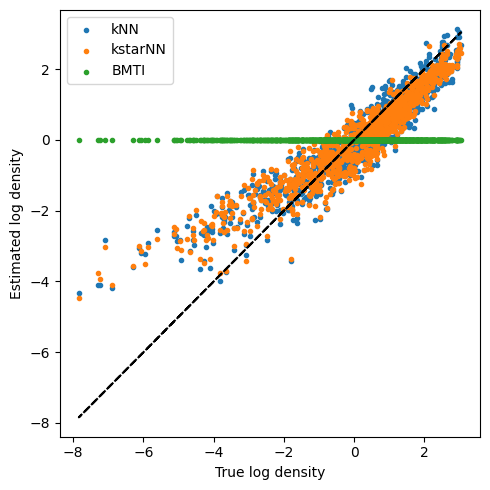

In [7]:
# plot real density vs estimated density
plt.figure(figsize=(5, 5))
plt.scatter(true_log_den, log_den_kNN, marker=".", label="kNN")
plt.scatter(true_log_den, log_den_kstarNN, marker=".", label="kstarNN")
plt.scatter(true_log_den, log_den_BMTI, marker=".", label="BMTI")
plt.plot(true_log_den, true_log_den, "k--")
plt.xlabel("True log density")
plt.ylabel("Estimated log density")
plt.legend()
plt.tight_layout()

In [8]:
# compute Mean Absolute Errors (MAEs)
MAE_kNN = np.mean(np.abs(log_den_kNN - true_log_den))
MAE_kstarNN = np.mean(np.abs(log_den_kstarNN - true_log_den))
MAE_BMTI = np.mean(np.abs(log_den_BMTI - true_log_den))

print("MAE kNN: ", MAE_kNN)
print("MAE kstarNN: ", MAE_kstarNN)
print("MAE BMTI: ", MAE_BMTI)

MAE kNN:  0.5440707536088479
MAE kstarNN:  0.547905663765867
MAE BMTI:  1.4255311


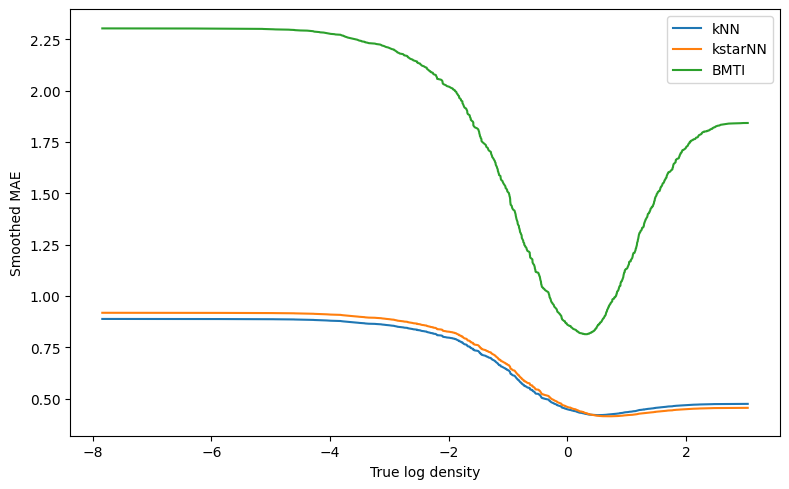

In [9]:
# sort indices in order of increasing true log-density
sortlden = true_log_den.argsort()

# plot MAE as a function of true log-density
plt.figure(figsize=(8, 5))

plt.plot(true_log_den[sortlden],gaussian_filter1d(np.abs((log_den_kNN-true_log_den)[sortlden]),sigma=200),label="kNN")
plt.plot(true_log_den[sortlden],gaussian_filter1d(np.abs((log_den_kstarNN-true_log_den)[sortlden]),sigma=200),label="kstarNN")
plt.plot(true_log_den[sortlden],gaussian_filter1d(np.abs((log_den_BMTI-true_log_den)[sortlden]),sigma=200),label="BMTI")


plt.xlabel("True log density")
plt.ylabel("Smoothed MAE")
plt.legend()
plt.tight_layout()